In [1]:
import json
import glob
import itertools

import numpy as np
import pandas as pd

from qiskit import transpile, QuantumCircuit
from qiskit.providers.fake_provider import FakeLima, ConfigurableFakeBackend
from qiskit.primitives import Estimator, BackendEstimator
from qiskit.providers import Options
from qiskit.circuit.random import random_circuit
from qiskit.quantum_info import random_clifford
from qiskit.quantum_info import SparsePauliOp

import torch
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.nn.functional import dropout

from torch_geometric.nn import (
    GCNConv, 
    TransformerConv, 
    GATv2Conv, 
    global_mean_pool, 
    Linear, 
    ChebConv, 
    SAGEConv,
    ASAPooling,
    dense_diff_pool,
    avg_pool_neighbor_x
)
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.utils import to_dense_adj, to_dense_batch

from tqdm.notebook import tqdm_notebook
import matplotlib.pyplot as plt
import seaborn as sns

from blackwater.data.loaders.exp_val import CircuitGraphExpValMitigationDataset
from blackwater.data.generators.exp_val import exp_value_generator
from blackwater.data.utils import generate_random_pauli_sum_op
from blackwater.library.ngem.estimator import ngem

from blackwater.data.utils import (
    generate_random_pauli_sum_op,
    create_estimator_meas_data,
    circuit_to_graph_data_json,
    get_backend_properties_v1,
    encode_pauli_sum_op,
    create_meas_data_from_estimators
)
from blackwater.data.generators.exp_val import ExpValueEntry
from blackwater.metrics.improvement_factor import improvement_factor, Trial, Problem

from pprint import pprint

from qiskit.opflow import I, X, Z
from qiskit.primitives import Estimator
from qiskit.circuit.library import TwoLocal
from qiskit.algorithms.minimum_eigensolvers import VQE, VQEResult
from qiskit.algorithms.optimizers import SLSQP, SPSA, COBYLA

from qiskit_aer.primitives import Estimator as AerEstimator
from qiskit_aer import AerSimulator

In [2]:
from qiskit.opflow import PauliTrotterEvolution, StateFn, PauliExpectation
from qiskit.opflow import CircuitSampler, PauliOp
from qiskit.opflow import I, X, Y, Z, Zero, One, Plus, Minus
from qiskit.circuit import Parameter

In [3]:
# backend = ConfigurableFakeBackend("Tashkent", n_qubits=2, version=1,
#                                  # qubit_t1=0.00011377694598809795,
#                                  # qubit_t2=0.00010553074510239035
#                                  ) #FakeLima()
backend = FakeLima()
properties = get_backend_properties_v1(backend)

ideal_estimator = AerEstimator(skip_transpilation=True) #Estimator()
aer_esimator = AerEstimator(skip_transpilation=True)
backend_estimator = BackendEstimator(backend, skip_transpilation=True)

## Many body dynamics

In [4]:
import numpy as np
import random
from qiskit import QuantumCircuit
from qiskit.circuit.library import U3Gate, CZGate, PhaseGate, CXGate

def construct_mbl_circuit(num_qubit, disorder, theta, steps):
    """Construct the circuit for Floquet dynamics of an MBL circuit.

    Args:
        num_spins (int): Number of spins. Must be even.
        W (float): Disorder strength up to np.pi.
        theta (float): Interaction strength up to np.pi.
        steps (int): Number of steps.
    """
    qc = QuantumCircuit(num_qubit)

    # Hard domain wall initial state
    # Qubits 0 to num_qubit/2 - 1 are up, and qubits num_qubit/2 to num_qubit - 1 are down
    for qubit_idx in range(num_qubit):
        if qubit_idx % 2 == 1:
            qc.x(qubit_idx)

    ## Floquet evolution
    for step in range(steps):
        # Interactions between even layers
        for even_qubit in range(0, num_qubit, 2):
            qc.append(CZGate(), (even_qubit, even_qubit+1))
            qc.append(U3Gate(theta, 0, -np.pi), [even_qubit])
            qc.append(U3Gate(theta, 0, -np.pi), [even_qubit+1])
        # Interactions between odd layers
        for odd_qubit in range(1, num_qubit-1, 2):
            qc.append(CZGate(), (odd_qubit, odd_qubit+1))
            qc.append(U3Gate(theta, 0, -np.pi), [odd_qubit])
            qc.append(U3Gate(theta, 0, -np.pi), [odd_qubit+1])
        # Apply RZ disorder
        for q in range(num_qubit):
            qc.append(PhaseGate(disorder[q]), [q])

    # Measure Z^{\otimes num_qubit}, or the all-Z operator from which all Z, ZZ, ... operators can be computed
    qc.measure_all()

    return qc

def generate_disorder(n_qubits, disorder_strength = np.pi, seed=0):
    """Generate disorder

    Args:
        n_qubits (int): Number of qubits
        disorder_strength (float, optional): Scales disorder strength from min/max of -pi/pi. Defaults to pi.

    Returns:
        List[float]: List of angles in single-qubit phase gates that correspond to disorders
    """
    random.seed(seed)
    disorder = [np.random.uniform(-1 * disorder_strength, disorder_strength) for _ in range(n_qubits)]
    return disorder

def cal_z_exp(counts):
        """
        Compute all sigma_z expectations values.

        Parameters
        ----------
        counts : dict
            Dictionary of state labels (keys, e.g. '000', '001')

        Returns
        -------
        z_exp : list of float
            sigma_z expectation values, where len(z_exp) is the number of qubits
        """
        shots = sum(list(counts.values()))
        num_qubits = len(list(counts.keys())[0])
        count_pos_z = np.zeros(num_qubits) # counts of positive z
        # Convert all keys into arrays
        for key, val in counts.items():
            count_pos_z += val * np.array(list(key), dtype=int)
        count_neg_z = np.ones(num_qubits) * shots - count_pos_z # counts of negative z
        z_exp = (count_pos_z - count_neg_z) / shots
        return z_exp

def calc_imbalance(single_z_dataset, even_qubits, odd_qubits):
        """Calculate the charge imbalance from the single-Z expectation values.

        Args:
            single_z_dataset (list[list[float]]): Single-Z expectation values. First index is qubits, second index is expectation value at each time
            even_qubits (list[int]): Indices of even qubits
            odd_qubits (list[int]): Indices of odd qubits

        Returns:
            imbalance list[float]: Charge imbalance
        """
        num_qubit = len(even_qubits)+len(odd_qubits)
        num_steps = len(single_z_dataset)
        imbalance = np.zeros(num_steps)
        for step in range(num_steps):
            ib = 0
            for qubit in range(num_qubit):
                if qubit in even_qubits:
                    ib += single_z_dataset[step][qubit]
                elif qubit in odd_qubits:
                    ib -= single_z_dataset[step][qubit]
                else:
                    print(f'Warning: The index {i} was not in even_qubits or odd_qubits')
            imbalance[step] = ib / num_qubit
        return imbalance



In [5]:
## Set the physics parameters
## No need to change W and theta
## Change `num_spins` for system size, `max_steps` to evolve deeper (2Q gate depth of 2 per step), and 
## `seed` for different disorders for when we do the disorder-averaged time-dependent charge imbalance
num_spins = 4 # Number of spins. Must be even.
W = 0.8 * np.pi # Disorder strength up to np.pi
theta = 0.05 * np.pi # Interaction strength up to np.pi
max_steps = 10
seed = 2 # Seed for the randomly generated array of disorder potentials

disorders = generate_disorder(num_spins, W, seed=seed)

qc_list = []
for steps in range(max_steps):
    qc_list.append(construct_mbl_circuit(num_spins, disorders, theta, steps))

# Take a look at the circuit to make sure it's got the correct brickwork style
s = {'fold': -1}
qc_list[3].draw(**s)

┌───────────────┐ ┌──────────┐                                     ┌───────────────┐ ┌──────────┐                                     ┌───────────────┐ ┌──────────┐                                   ░ ┌─┐         
   q_0: ──────■─┤ U3(π/20,0,-π) ├─┤ P(1.842) ├───────────────────────────────────■─┤ U3(π/20,0,-π) ├─┤ P(1.842) ├───────────────────────────────────■─┤ U3(π/20,0,-π) ├─┤ P(1.842) ├───────────────────────────────────░─┤M├─────────
        ┌───┐ │ ├───────────────┤ └──────────┘ ┌───────────────┐ ┌───────────┐   │ ├───────────────┤ └──────────┘ ┌───────────────┐ ┌───────────┐   │ ├───────────────┤ └──────────┘ ┌───────────────┐ ┌───────────┐   ░ └╥┘┌─┐      
   q_1: ┤ X ├─■─┤ U3(π/20,0,-π) ├──────■───────┤ U3(π/20,0,-π) ├─┤ P(-1.032) ├───■─┤ U3(π/20,0,-π) ├──────■───────┤ U3(π/20,0,-π) ├─┤ P(-1.032) ├───■─┤ U3(π/20,0,-π) ├──────■───────┤ U3(π/20,0,-π) ├─┤ P(-1.032) ├───░──╫─┤M├──────
        └───┘   ├───────────────┤      │       ├───────────────┤┌┴───────────┴─┐   ├───────────────┤      │       ├───────────────┤┌┴───────────┴─┐   ├───────────────┤      │       ├───────────────┤┌┴───────────┴─┐ ░  ║ └╥┘┌─┐   
   q_2: ──────■─┤ U3(π/20,0,-π) ├──────■───────┤ U3(π/20,0,-π) ├┤ P(-0.042648) ├─■─┤ U3(π/20,0,-π) ├──────■───────┤ U3(π/20,0,-π) ├┤ P(-0.042648) ├─■─┤ U3(π/20,0,-π) ├──────■───────┤ U3(π/20,0,-π) ├┤ P(-0.042648) ├─░──╫──╫─┤M├───
        ┌───┐ │ ├───────────────┤┌────────────┐└───────────────┘└──────────────┘ │ ├───────────────┤┌────────────┐└───────────────┘└──────────────┘ │ ├───────────────┤┌────────────┐└───────────────┘└──────────────┘ ░  ║  ║ └╥┘┌─┐
   q_3: ┤ X ├─■─┤ U3(π/20,0,-π) ├┤ P(-1.0113) ├──────────────────────────────────■─┤ U3(π/20,0,-π) ├┤ P(-1.0113) ├──────────────────────────────────■─┤ U3(π/20,0,-π) ├┤ P(-1.0113) ├──────────────────────────────────░──╫──╫──╫─┤M├
        └───┘   └───────────────┘└────────────┘                                    └───────────────┘└────────────┘                                    └───────────────┘└────────────┘                                  ░  ║  ║  ║ └╥┘
meas_0: ══════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╩══╬══╬══╬═
                                                                                                                                                                                                                             ║  ║  ║ 
meas_1: ═════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╩══╬══╬═
                                                                                                                                                                                                                                ║  ║ 
meas_2: ════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╩══╬═
                                                                                                                                                                                                                                   ║ 
meas_3: ═══════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╩═

In [6]:
## Set up the backend
from qiskit import IBMQ
from qiskit_aer import AerSimulator, QasmSimulator
from qiskit.providers.fake_provider import FakeMontreal, FakeLima

## Local
backend_ideal = QasmSimulator() # Noiseless
backend_noisy = AerSimulator.from_backend(FakeLima()) # Noisy

# ## Remote
# IBMQ.load_account() # When setting up this notebook to use IBMQ devices for the first time, save your account credentials locally by following https://github.com/Qiskit/qiskit-ibmq-provider#configure-your-ibm-quantum-credentials
# hub='ibm-q-internal'; group='deployed'; project='default' # Replace these with your own credentials
# provider = IBMQ.get_provider(hub=hub, group=group, project=project)
# backend = provider.get_backend('ibmq_mumbai') # Pro tip: For fast, noiseless simulations up to 32 qubits, you can use 'ibmq_qasm_simulator' remotely

run_config_ideal = {'shots': 10000, 'backend': backend_ideal, 'name': 'ideal'}
run_config_noisy = {'shots': 10000, 'backend': backend_noisy, 'name': 'noisy'}

In [7]:
## Run the circuits
from qiskit import execute

job_ideal = execute(qc_list, **run_config_ideal)
job_noisy = execute(transpile(qc_list, backend_noisy), **run_config_noisy)

In [8]:
## Compute the expectation values
even_qubits = np.linspace(0, num_spins, int(num_spins/2), endpoint=False)
odd_qubits = np.linspace(1, num_spins+1, int(num_spins/2), endpoint=False)

exp_Z_ideal = []
exp_Z_noisy = []
imbalance_ideal = []
imbalance_noisy = []
for i in range(len(qc_list)):
    counts_ideal = job_ideal.result().get_counts()[i]
    counts_noisy = job_noisy.result().get_counts()[i]
    exp_Z_ideal.append(list(cal_z_exp(counts_ideal))) # Single-Z expectation value of each qubit
    exp_Z_noisy.append(list(cal_z_exp(counts_noisy))) # Single-Z expectation value of each qubit

imbalance_ideal = calc_imbalance(exp_Z_ideal, even_qubits, odd_qubits)
imbalance_noisy = calc_imbalance(exp_Z_noisy, even_qubits, odd_qubits)

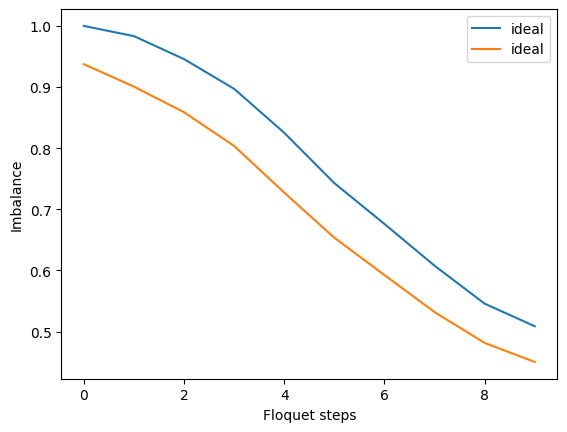

In [9]:
## Plot the results
import matplotlib.pyplot as plt

plt.plot(imbalance_ideal, label="ideal")
plt.plot(imbalance_noisy, label="ideal")

plt.xlabel('Floquet steps')
plt.ylabel('Imbalance')
plt.legend()
plt.show()

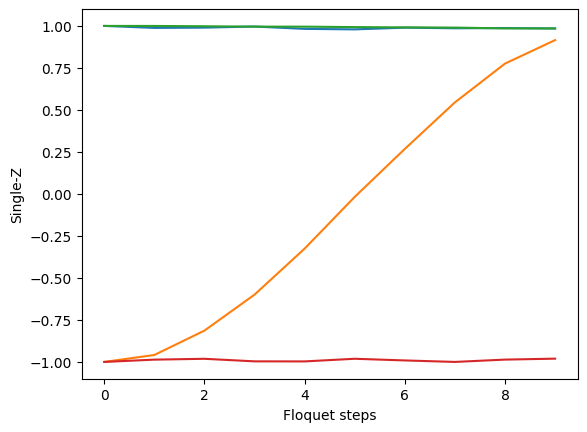

In [10]:
# Plot single-Z expectation values
for i in range(num_spins):
    single_z = []
    for step in range(max_steps):
        single_z.append(exp_Z_ideal[step][i])
    plt.plot(single_z)
plt.xlabel('Floquet steps')
plt.ylabel('Single-Z')
plt.show()

In [ ]:
## Now we need to average over many disorders
num_disorders = 30
    
# For each disorder realization, make a new disorder
# and compute the charge imbalance using the same physics parameters as before
imbalance_all_ideal = []
imbalance_all_noisy = []

for disorder_realization in tqdm_notebook(range(num_disorders)):
    disorders = generate_disorder(num_spins, W, seed=disorder_realization)

    qc_list = []
    for steps in range(max_steps):
        qc_list.append(construct_mbl_circuit(num_spins, disorders, theta, steps))

    job_ideal = execute(qc_list, **run_config_ideal)
    job_noisy = execute(transpile(qc_list, backend_noisy), **run_config_noisy)

    exp_Z_ideal = []
    exp_Z_noisy = []

    for i in range(len(qc_list)):
        counts_ideal = job_ideal.result().get_counts()[i]
        counts_noisy = job_noisy.result().get_counts()[i]

        exp_Z_ideal.append(list(cal_z_exp(counts_ideal))) # Single-Z expectation value of each qubit
        exp_Z_noisy.append(list(cal_z_exp(counts_noisy))) # Single-Z expectation value of each qubit

    imbalance_ideal = calc_imbalance(exp_Z_ideal, even_qubits, odd_qubits)
    imbalance_noisy = calc_imbalance(exp_Z_noisy, even_qubits, odd_qubits)

    imbalance_all_ideal.append(imbalance_ideal)
    imbalance_all_noisy.append(imbalance_noisy)

# Average imbalance
imbalance_ideal_average = np.mean(imbalance_all_ideal, axis=0)
imbalance_noisy_average = np.mean(imbalance_all_noisy, axis=0)

Text(0, 0.5, 'Imbalance')

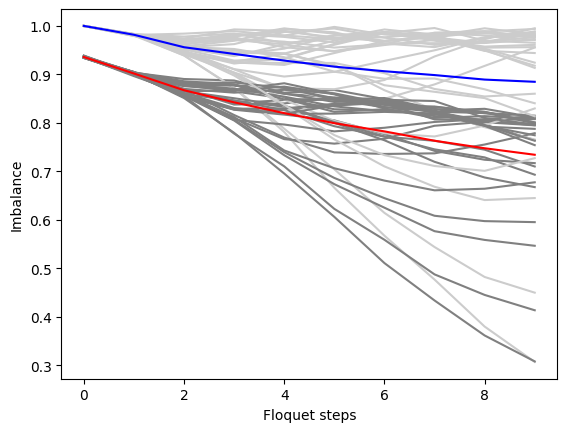

In [12]:
## Plot

for disorder_realization in range(num_disorders):
    plt.plot(imbalance_all_ideal[disorder_realization], color="0.8")
    plt.plot(imbalance_all_noisy[disorder_realization], color="0.5")

plt.plot(imbalance_ideal_average, color='blue')
plt.plot(imbalance_noisy_average, color='red')

plt.xlabel('Floquet steps')
plt.ylabel('Imbalance')

In [12]:
from pathlib import Path

### Generate data

In [16]:
def generate_data(save_path: str, n_entries_per_file: int):    
    for steps in range(max_steps):
        
        entries = []
        
        for disorder_realization in tqdm_notebook(range(n_entries_per_file)):
            disorders = generate_disorder(num_spins, W, seed=disorder_realization)

            circuit = construct_mbl_circuit(num_spins, disorders, theta, steps)
            circuit = transpile(circuit, backend_noisy, optimization_level=3)
            
            job_ideal = execute(circuit, **run_config_ideal)
            job_noisy = execute(circuit, **run_config_noisy)
            
            counts_ideal = job_ideal.result().get_counts()
            counts_noisy = job_noisy.result().get_counts()
                        
            ideal_exp_val = cal_z_exp(counts_ideal)
            noisy_exp_val = cal_z_exp(counts_noisy)
                        
            graph_data = circuit_to_graph_data_json(
                circuit=circuit,
                properties=properties,
                use_qubit_features=True,
                use_gate_features=True,
            )
            
            entry = ExpValueEntry(
                circuit_graph=graph_data,
                observable=[],
                ideal_exp_value=ideal_exp_val.tolist(),
                noisy_exp_values=[
                    noisy_exp_val.tolist()
                ],
                circuit_depth=circuit.depth()
            )
            entries.append(entry.to_dict())
            
        path = f"{save_path}/step_{steps}.json"
        with open(path, "w") as f:
            # pprint(entries)
            json.dump(entries, f)

In [20]:
# generate_data("./data/mbd_datasets/train/", 500)

In [19]:
# generate_data("./data/mbd_datasets/val/", 200)

In [21]:
train_paths = glob.glob("./data/mbd_datasets/train/step_**.json")
val_paths = glob.glob("./data/mbd_datasets/val/step_**.json")

In [134]:
train_paths = [
    './data/mbd_datasets/train/step_5.json',
    './data/mbd_datasets/train/step_4.json',
    './data/mbd_datasets/train/step_3.json',
    './data/mbd_datasets/train/step_2.json',
    './data/mbd_datasets/train/step_1.json',
    './data/mbd_datasets/train/step_0.json',
    './data/mbd_datasets/train/step_6.json'
]
val_paths = [
     './data/mbd_datasets/val/step_5.json',
     './data/mbd_datasets/val/step_4.json',
     './data/mbd_datasets/val/step_3.json',
     './data/mbd_datasets/val/step_2.json',
     './data/mbd_datasets/val/step_1.json',
     './data/mbd_datasets/val/step_0.json',
     './data/mbd_datasets/val/step_6.json'
]

In [149]:
BATCH_SIZE = 32

train_loader = DataLoader(
    CircuitGraphExpValMitigationDataset(
        train_paths,
    ),
    batch_size=BATCH_SIZE,
    shuffle=True
)

val_loader = DataLoader(
    CircuitGraphExpValMitigationDataset(
        val_paths,
    ),
    batch_size=BATCH_SIZE,
    shuffle=False
)

for data in train_loader:
    print(data)
    break

DataBatch(x=[2883, 22], edge_index=[2, 6007], edge_attr=[3124, 3], y=[32, 1, 4], observable=[32, 0], circuit_depth=[32, 1], noisy_0=[32, 1, 4], batch=[2883], ptr=[33])


In [150]:
class ExpValCircuitGraphModel(torch.nn.Module):
    def __init__(
        self,
        num_node_features: int,
        hidden_channels: int
    ):
        super().__init__()
        
        self.transformer1 = TransformerConv(
            num_node_features, hidden_channels,
            heads=3,
            dropout=0.1
        )
        self.pooling1 = ASAPooling(hidden_channels * 3, 0.5)

        self.transformer2 = TransformerConv(
            hidden_channels * 3, hidden_channels,
            heads=2,
            dropout=0.1
        )
        self.pooling2 = ASAPooling(hidden_channels * 2, 0.5)
        
        self.body_seq = torch.nn.Sequential(
            Linear(hidden_channels * 2 + 5, hidden_channels),
            torch.nn.Dropout(0.2),
            Linear(hidden_channels, 4)
        )

    def forward(self, 
                exp_value, observable, 
                circuit_depth, nodes, 
                edge_index, batch):
        graph = self.transformer1(nodes, edge_index)    
        graph, edge_index, _, batch, _ = self.pooling1(
            graph, edge_index, batch=batch
        )
        
        graph = self.transformer2(graph, edge_index)
        graph, edge_index, _, batch, _ = self.pooling2(
            graph, edge_index, batch=batch
        )
        
        graph = global_mean_pool(graph, batch)
    
        merge = torch.cat((
            graph, 
            torch.squeeze(exp_value, 1),
            circuit_depth
        ), dim=1)

        return self.body_seq(merge)

In [151]:
model = ExpValCircuitGraphModel(
    num_node_features=22, 
    hidden_channels=15
)
criterion = torch.nn.MSELoss()

In [152]:
optimizer = Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, 
                              'min', 
                              factor=0.1, 
                              patience=15, 
                              verbose=True, 
                              min_lr=0.00001)

In [ ]:
min_valid_loss = np.inf

train_losses = []
val_losses = []

N_EPOCHS = 100

progress = tqdm_notebook(range(N_EPOCHS), desc='Model training', leave=True)
for epoch in progress:
    train_loss = 0.0
    model.train()
    for i, data in enumerate(train_loader):
        optimizer.zero_grad()

        out = model(
            data.noisy_0, 
            data.observable, 
            data.circuit_depth,
            data.x, 
            data.edge_index, 
            data.batch
        )
        loss = criterion(out, torch.squeeze(data.y, 1))        
        
        train_loss += loss.item()
        
        loss.backward()
        optimizer.step()
                
    valid_loss = 0.0
    model.eval()
    for i, data in enumerate(val_loader):
        out = model(
            data.noisy_0, 
            data.observable, 
            data.circuit_depth, 
            data.x, 
            data.edge_index, 
            data.batch)
        loss = criterion(out, torch.squeeze(data.y, 1))        

        valid_loss += loss.item()

    scheduler.step(valid_loss)

    if epoch >= 1:    
        train_losses.append(train_loss / len(train_loader))
        val_losses.append(valid_loss / len(val_loader))

        progress.set_description(f"{round(train_losses[-1], 5)}, {round(val_losses[-1], 5)}")
        progress.refresh()

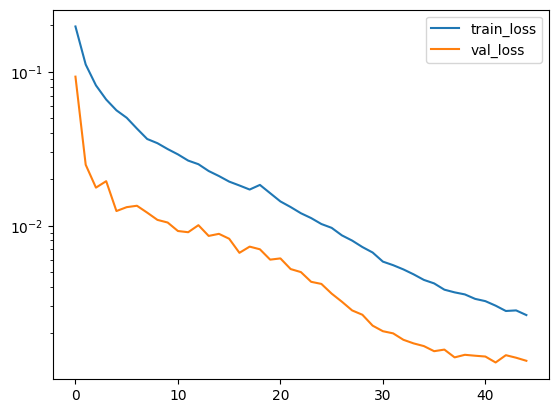

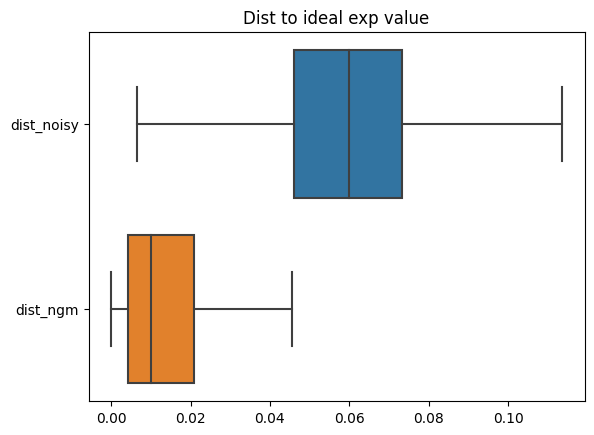

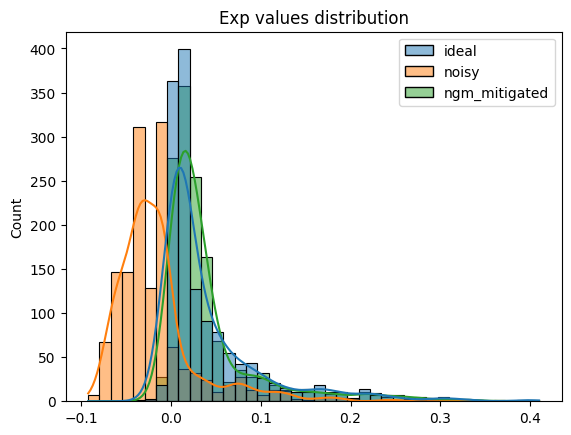

In [154]:
plt.plot(train_losses, label="train_loss")
plt.plot(val_losses, label="val_loss")
plt.yscale('log')

plt.legend()
plt.show()

distances = []
for i, data in enumerate(val_loader):
    out = model(data.noisy_0, data.observable, data.circuit_depth, data.x, data.edge_index, data.batch)
    
    for ideal, noisy, ngm_mitigated in zip(
        data.y.tolist(),
        data.noisy_0.tolist(),
        out.tolist()
    ):
        ideal = np.mean(ideal)
        noisy = np.mean(noisy)
        ngm_mitigated = np.mean(ngm_mitigated)
        distances.append({
            "ideal": ideal,
            "noisy": noisy,
            "ngm_mitigated": ngm_mitigated,
            "dist_noisy": np.abs(ideal - noisy),
            "dist_ngm": np.abs(ideal - ngm_mitigated),
        })
        
df = pd.DataFrame(distances)
sns.boxplot(data=df[["dist_noisy", "dist_ngm"]], orient="h", showfliers = False)
plt.title("Dist to ideal exp value")
plt.show()

sns.histplot([df['ideal'], df['noisy'], df["ngm_mitigated"]], kde=True, bins=40)
plt.title("Exp values distribution")
plt.show()

In [155]:
model.eval()

ExpValCircuitGraphModel(
  (transformer1): TransformerConv(22, 15, heads=3)
  (pooling1): ASAPooling(45, ratio=0.5)
  (transformer2): TransformerConv(45, 15, heads=2)
  (pooling2): ASAPooling(30, ratio=0.5)
  (body_seq): Sequential(
    (0): Linear(35, 15, bias=True)
    (1): Dropout(p=0.2, inplace=False)
    (2): Linear(15, 4, bias=True)
  )
)

In [156]:
## Now we need to average over many disorders
num_disorders = 30
    
# For each disorder realization, make a new disorder
# and compute the charge imbalance using the same physics parameters as before
imbalance_all_ideal = []
imbalance_all_noisy = []
imbalance_all_mitigated = []

for disorder_realization in tqdm_notebook(range(num_disorders)):
    disorders = generate_disorder(num_spins, W, seed=disorder_realization)

    qc_list = []
    for steps in range(max_steps):
        qc_list.append(construct_mbl_circuit(num_spins, disorders, theta, steps))

    transpiled_qc_list = transpile(qc_list, backend_noisy, optimization_level=3)
    job_ideal = execute(qc_list, **run_config_ideal)
    job_noisy = execute(transpiled_qc_list, **run_config_noisy)

    exp_Z_ideal = []
    exp_Z_noisy = []
    exp_Z_mitigated = []

    
    for i in range(len(qc_list)):
        counts_ideal = job_ideal.result().get_counts()[i]
        counts_noisy = job_noisy.result().get_counts()[i]

        ideal_exp_val = cal_z_exp(counts_ideal)
        noisy_exp_val = cal_z_exp(counts_noisy)
        
        exp_Z_ideal.append(list(ideal_exp_val)) # Single-Z expectation value of each qubit
        exp_Z_noisy.append(list(noisy_exp_val)) # Single-Z expectation value of each qubit

        graph_data = circuit_to_graph_data_json(
            circuit=transpiled_qc_list[i],
            properties=properties,
            use_qubit_features=True,
            use_gate_features=True,
        )
        
        entry = ExpValueEntry(
            circuit_graph=graph_data,
            observable=[],
            ideal_exp_value=ideal_exp_val.tolist(),
            noisy_exp_values=[
                noisy_exp_val.tolist()
            ],
            circuit_depth=transpiled_qc_list[i].depth()
        ).to_pyg_data()
                
        # print(entry.batch)
        mitigated_exp_val = model(entry.noisy_0, 
                            entry.observable, 
                            entry.circuit_depth, 
                            entry.x, 
                            entry.edge_index, 
                            entry.batch).tolist()[0]
        
        exp_Z_mitigated.append(mitigated_exp_val)
        
    imbalance_ideal = calc_imbalance(exp_Z_ideal, even_qubits, odd_qubits)
    imbalance_noisy = calc_imbalance(exp_Z_noisy, even_qubits, odd_qubits)
    imbalance_mitigated = calc_imbalance(exp_Z_mitigated, even_qubits, odd_qubits)

    
    imbalance_all_ideal.append(imbalance_ideal)
    imbalance_all_noisy.append(imbalance_noisy)
    imbalance_all_mitigated.append(imbalance_mitigated)

# Average imbalance
imbalance_ideal_average = np.mean(imbalance_all_ideal, axis=0)
imbalance_noisy_average = np.mean(imbalance_all_noisy, axis=0)
imbalance_mitigated_average = np.mean(imbalance_all_mitigated, axis=0)

  0%|          | 0/30 [00:00<?, ?it/s]

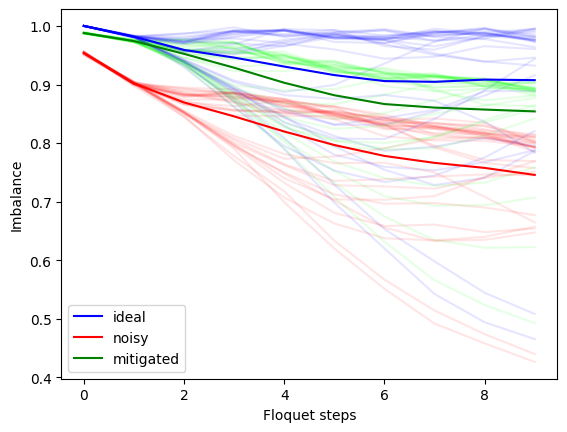

In [157]:
## Plot

for disorder_realization in range(num_disorders):
    plt.plot(imbalance_all_ideal[disorder_realization], color=(0.0, 0.0, 1.0, 0.1))
    plt.plot(imbalance_all_noisy[disorder_realization], color=(1.0, 0.0, 0.0, 0.1))
    plt.plot(imbalance_all_mitigated[disorder_realization], color=(0.0, 1.0, 0.0, 0.1))

plt.plot(imbalance_ideal_average, color='blue', label="ideal")
plt.plot(imbalance_noisy_average, color='red', label="noisy")
plt.plot(imbalance_mitigated_average, color='green', label="mitigated")

plt.xlabel('Floquet steps')
plt.ylabel('Imbalance')
plt.legend()
plt.show()

## extrapolation

In [164]:
## Now we need to average over many disorders
num_disorders = 30
    
# For each disorder realization, make a new disorder
# and compute the charge imbalance using the same physics parameters as before
imbalance_all_ideal = []
imbalance_all_noisy = []
imbalance_all_mitigated = []

for disorder_realization in tqdm_notebook(range(num_disorders)):
    disorders = generate_disorder(num_spins, W, seed=disorder_realization)

    qc_list = []
    for steps in range(max_steps + 5):
        qc_list.append(construct_mbl_circuit(num_spins, disorders, theta, steps))

    transpiled_qc_list = transpile(qc_list, backend_noisy, optimization_level=3)
    job_ideal = execute(qc_list, **run_config_ideal)
    job_noisy = execute(transpiled_qc_list, **run_config_noisy)

    exp_Z_ideal = []
    exp_Z_noisy = []
    exp_Z_mitigated = []

    
    for i in range(len(qc_list)):
        counts_ideal = job_ideal.result().get_counts()[i]
        counts_noisy = job_noisy.result().get_counts()[i]

        ideal_exp_val = cal_z_exp(counts_ideal)
        noisy_exp_val = cal_z_exp(counts_noisy)
        
        exp_Z_ideal.append(list(ideal_exp_val)) # Single-Z expectation value of each qubit
        exp_Z_noisy.append(list(noisy_exp_val)) # Single-Z expectation value of each qubit

        graph_data = circuit_to_graph_data_json(
            circuit=transpiled_qc_list[i],
            properties=properties,
            use_qubit_features=True,
            use_gate_features=True,
        )
        
        entry = ExpValueEntry(
            circuit_graph=graph_data,
            observable=[],
            ideal_exp_value=ideal_exp_val.tolist(),
            noisy_exp_values=[
                noisy_exp_val.tolist()
            ],
            circuit_depth=transpiled_qc_list[i].depth()
        ).to_pyg_data()
                
        mitigated_exp_val = model(entry.noisy_0, 
                            entry.observable, 
                            entry.circuit_depth, 
                            entry.x, 
                            entry.edge_index, 
                            entry.batch).tolist()[0]
        
        exp_Z_mitigated.append(mitigated_exp_val)
        
    imbalance_ideal = calc_imbalance(exp_Z_ideal, even_qubits, odd_qubits)
    imbalance_noisy = calc_imbalance(exp_Z_noisy, even_qubits, odd_qubits)
    imbalance_mitigated = calc_imbalance(exp_Z_mitigated, even_qubits, odd_qubits)

    
    imbalance_all_ideal.append(imbalance_ideal)
    imbalance_all_noisy.append(imbalance_noisy)
    imbalance_all_mitigated.append(imbalance_mitigated)

# Average imbalance
imbalance_ideal_average = np.mean(imbalance_all_ideal, axis=0)
imbalance_noisy_average = np.mean(imbalance_all_noisy, axis=0)
imbalance_mitigated_average = np.mean(imbalance_all_mitigated, axis=0)

  0%|          | 0/30 [00:00<?, ?it/s]

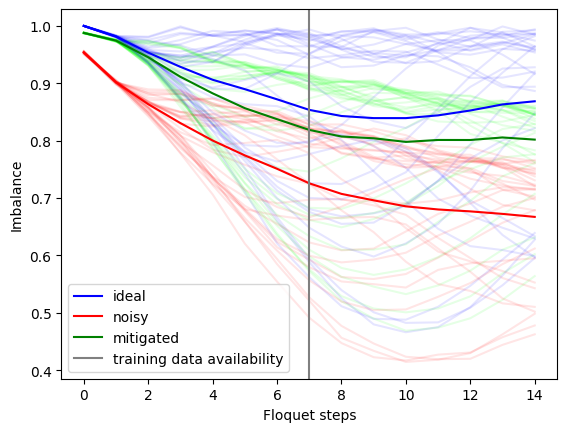

In [168]:
## Plot

for disorder_realization in range(num_disorders):
    plt.plot(imbalance_all_ideal[disorder_realization], color=(0.0, 0.0, 1.0, 0.1))
    plt.plot(imbalance_all_noisy[disorder_realization], color=(1.0, 0.0, 0.0, 0.1))
    plt.plot(imbalance_all_mitigated[disorder_realization], color=(0.0, 1.0, 0.0, 0.1))

plt.plot(imbalance_ideal_average, color='blue', label="ideal")
plt.plot(imbalance_noisy_average, color='red', label="noisy")
plt.plot(imbalance_mitigated_average, color='green', label="mitigated")

plt.axvline(x = 7, color = 'gray', label = 'training data availability')

plt.xlabel('Floquet steps')
plt.ylabel('Imbalance')
plt.legend()
plt.show()

In [130]:
# with open("results/mdb_20_steps_10_unseen_extrapolation.json", "w") as f:
#     results_data = {
#         "imbalance_all_ideal": [x.tolist() for x in imbalance_all_ideal],
#         "imbalance_all_noisy": [x.tolist() for x in imbalance_all_noisy],
#         "imbalance_all_mitigated": [x.tolist() for x in imbalance_all_mitigated],
#         "imbalance_ideal_average": imbalance_ideal_average.tolist(),
#         "imbalance_noisy_average": imbalance_noisy_average.tolist(),
#         "imbalance_mitigated_average": imbalance_mitigated_average.tolist() 
#     }
#     json.dump(results_data, f)